# RNN and CNN Text Text Classification

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pprint
from sklearn.utils import shuffle

from tqdm.auto import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [51]:
pip install datasets torchinfo

In [52]:
from torchinfo import summary

In [53]:
from datasets import load_dataset
ds = load_dataset("emotion")

In [54]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [55]:
train = pd.DataFrame(ds['train'])
val = pd.DataFrame(ds['validation'])
test = pd.DataFrame(ds['test'])

In [56]:
X_train, X_test, y_train, y_test =  train['text'], test['text'], train['label'], test['label']

In [57]:
X_train, X_val, y_train, y_val =  train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [58]:
X_train, X_val, X_test, y_train, y_val, y_test =  train['text'], val['text'], test['text'], train['label'], val['label'], test['label']

In [59]:
for w in X_train[0].lower().split():
    print(w)

i
didnt
feel
humiliated


In [60]:
assert(len(y_test) == len(X_test))

In [61]:
pad_token = "PAD"
unk_token = "UNK"
pad_token_id = 0
unk_token_id = 1

In [62]:
def getDictionary(corpus, unk_token=unk_token, pad_token=pad_token, word_count_threshold=2):
    dictionary = {}

    for sentence in corpus:
        for word in sentence.lower().split():
            if word in dictionary:
                dictionary[word] += 1
            else:
                dictionary[word] = 1

    words = [pad_token, unk_token] + \
        [w for w in sorted(dictionary) if dictionary[w] > word_count_threshold]

    word2id = {w: i for i, w in enumerate(words)}
    id2word  = {i: w for w, i in word2id.items()}
    return word2id, id2word

In [63]:
def getVocab(texts, unk_token=unk_token, pad_token=pad_token):
    word2id = {pad_token : 0, unk_token : 1}
    index = 2

    for sentence in texts:
        for word in sentence.lower().split():
            if word2id.get(word, None) == None:
                word2id[word] = index
                index += 1

    id2word  = {v: k for k, v in word2id.items()}
    return word2id, id2word


In [64]:
def tokenizeTexts(texts, word2id, unk_token_id=unk_token_id):
    result = []

    for sentence in texts:
        sentence_tokenized = []

        for word in sentence.lower().split():
            sentence_tokenized.append(word2id.get(word, unk_token_id))

        result.append(sentence_tokenized)

    return result

In [65]:
def decodeTexts(tokens, id2word, unk_token=unk_token):
    result = []

    for sentence in tokens:
        sentence_decoded = []

        for word in sentence:
            sentence_decoded.append(id2word.get(word, unk_token))

        result.append(sentence_decoded)

    return result

In [66]:
word2id, id2word = getDictionary(X_train)

In [67]:
len(word2id)

5260

In [68]:
VOCAB_SIZE = len(word2id)

In [69]:
text = tokenizeTexts(X_train, word2id)[0]

In [70]:
len(text)

4

In [71]:
decodeTexts([text], id2word)

[['i', 'didnt', 'feel', 'humiliated']]

In [72]:
X_train_tokenized   = tokenizeTexts(X_train, word2id)
X_val_tokenized     = tokenizeTexts(X_val, word2id)
X_test_tokenized    = tokenizeTexts(X_test, word2id)

## Data generator

#### The proper way to do this is to sort the batches in decending order and to use torch.nn.utils.rnn.pad_packed_sequence and torch.nn.utils.rnn.pack_padded_sequence and to sort each batch in reverse ordered by the length of each text

In [73]:
def dataGenerator(X, y, batch_size=32, shuffle_data=True, pad_token_id=pad_token_id):

    if shuffle_data:
        X, y = shuffle(X, y)

    n_batches = int(np.ceil(len(y) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(y))

        X_batch = X[batch * batch_size:end]
        y_batch = y[batch * batch_size:end]

        max_len = np.max([len(x) for x in X_batch])
        for sample in range(len(X_batch)):
            x = X_batch[sample]
            pad = [pad_token_id] * (max_len - len(x))
            X_batch[sample] = pad + x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield X_batch, y_batch

In [74]:
train_gen   = lambda : dataGenerator(X_train_tokenized, y_train.tolist())
val_gen     = lambda : dataGenerator(X_val_tokenized  , y_val.tolist(), shuffle_data=False)
test_gen    = lambda : dataGenerator(X_test_tokenized , y_test.tolist(), shuffle_data=False)

In [75]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0
    steps = 0

    for X, y in data_loader():
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        steps += 1

    return train_loss / steps, train_acc / steps


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0
    steps = 0

    with torch.inference_mode():
        for X, y in data_loader():

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            steps += 1

    return test_loss / steps, test_acc / steps

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def getPredsAndTrue(model, data_loader, device):

    model.eval()


    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader():

            X = X.to(device)

            y_pred = model(X)

            y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    return torch.cat(y_preds), torch.cat(y_true)

## RNN

In [76]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, hidden_size, n_layers, n_outputs, bidirectional=False, dropout=0):
        super(RNN, self).__init__()
        self.n_vocab = n_vocab
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.out_dim = n_outputs
        self.bi = bidirectional

        self.embed = nn.Embedding(self.n_vocab, self.embed_dim)

        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )

        if self.bi:
            self.fc = nn.Linear(hidden_size * 2 , self.out_dim)
        else:
            self.fc = nn.Linear(hidden_size , self.out_dim)


    def forward(self, x):
        # x.shape [n_samples, max_seq_len]

        if self.bi:
            h0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size).to(device)
            c0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size).to(device)
        else:
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        # h0.shape = c0.shape: [n_layers, n_samples, hidden_size]

        x = self.embed(x.to(torch.int64))
        # x.shape [n_samples, max_seq_len, embed_dim]
        x, (h_out, c_out) = self.rnn(x, (h0, c0))
        # x.shape [n_samples, max_seq_len, hidden_size]=

        x, _ = torch.max(x, 1)
        # x.shape [n_samples, hidden_size]

        x = self.fc(x)

        return x

In [77]:
rnn_model = RNN(n_vocab=VOCAB_SIZE, embed_dim=128, hidden_size=96, n_layers=2, n_outputs=6, bidirectional=True, dropout=0.5)

print(rnn_model)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=5e-4)

RNN(
  (embed): Embedding(5260, 128)
  (rnn): LSTM(128, 96, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=192, out_features=6, bias=True)
)


In [78]:
import torchinfo

In [105]:
rnn2_model = RNN(n_vocab=VOCAB_SIZE, embed_dim=128, hidden_size=96, n_layers=1, n_outputs=6, bidirectional=True, dropout=0.5)
torchinfo.summary(rnn2_model, (1 , 64))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 128]              673,280
├─LSTM: 1-2                              [1, 64, 192]              173,568
├─Linear: 1-3                            [1, 6]                    1,158
Total params: 848,006
Trainable params: 848,006
Non-trainable params: 0
Total mult-adds (M): 11.78
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 3.39
Estimated Total Size (MB): 3.56

In [108]:
((4 * 128 * 96) + (4 * 96 * 96) ) * 2

172032

In [110]:
((4 * 192 * 96) + (4 * 96 * 96) ) * 2 + ((4 * 128 * 96) + (4 * 96 * 96) ) * 2

393216

In [79]:
torchinfo.summary(rnn_model, (1 , 64))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 128]              673,280
├─LSTM: 1-2                              [1, 64, 192]              396,288
├─Linear: 1-3                            [1, 6]                    1,158
Total params: 1,070,726
Trainable params: 1,070,726
Non-trainable params: 0
Total mult-adds (M): 26.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 4.28
Estimated Total Size (MB): 4.45

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5111 | train_acc: 39.2625 | test_loss: 1.2627 | test_acc: 53.2738 | time: 2.3538
Epoch: 2 | train_loss: 0.8726 | train_acc: 67.7562 | test_loss: 0.5701 | test_acc: 80.0099 | time: 3.7397
Epoch: 3 | train_loss: 0.3961 | train_acc: 85.9188 | test_loss: 0.3667 | test_acc: 87.0536 | time: 3.3799
Epoch: 4 | train_loss: 0.2310 | train_acc: 91.8375 | test_loss: 0.3042 | test_acc: 88.9881 | time: 3.6667
Epoch: 5 | train_loss: 0.1655 | train_acc: 93.6125 | test_loss: 0.2840 | test_acc: 90.8234 | time: 3.1843
Epoch: 6 | train_loss: 0.1203 | train_acc: 95.1875 | test_loss: 0.2697 | test_acc: 91.0714 | time: 4.1242
Epoch: 7 | train_loss: 0.0970 | train_acc: 96.1688 | test_loss: 0.2874 | test_acc: 90.2778 | time: 3.8071
Epoch: 8 | train_loss: 0.0741 | train_acc: 96.9688 | test_loss: 0.3032 | test_acc: 90.3274 | time: 3.3342
Epoch: 9 | train_loss: 0.0631 | train_acc: 97.5250 | test_loss: 0.3399 | test_acc: 90.6250 | time: 2.4395
Epoch: 10 | train_loss: 0.0543 | train_acc: 97

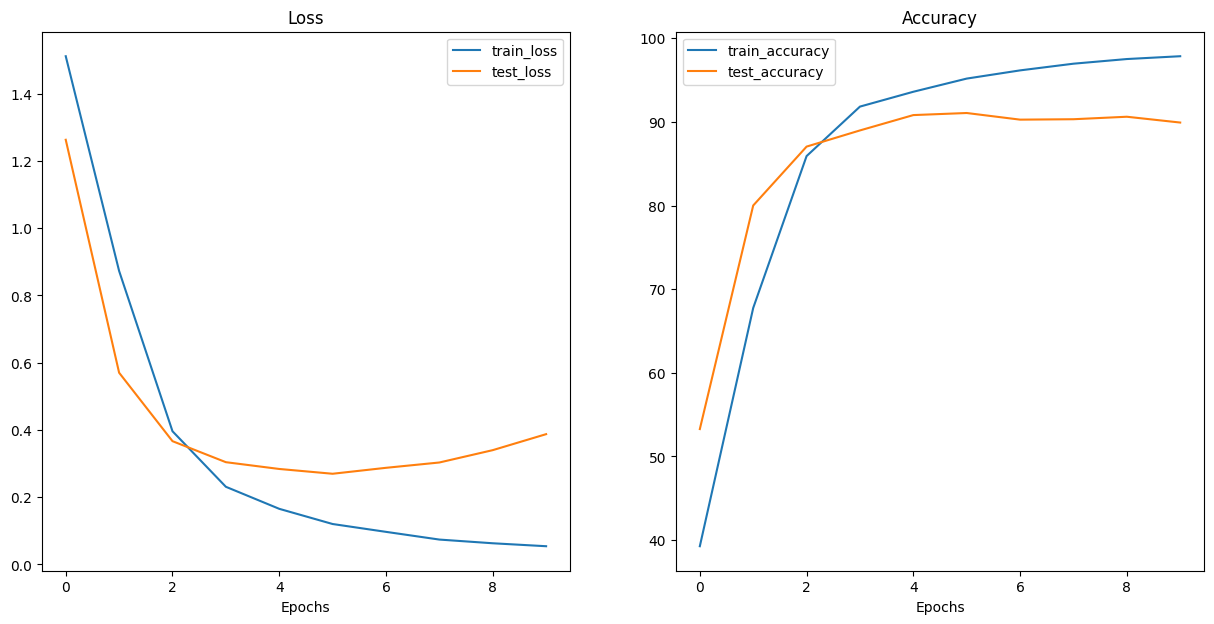

In [80]:
results = train(model=rnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

## CNN

In [81]:
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.n_vocab = n_vocab
        self.embed_dim = embed_dim
        self.out_dim = n_outputs

        self.embed = nn.Embedding(self.n_vocab, self.embed_dim)

        self.conv1 = nn.Conv1d(self.embed_dim, 32, 3, padding='same')
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 32, 3, padding='same')

        self.fc = nn.Linear(32, self.out_dim)

    def forward(self, text):
        # x.shape [n_samples, max_seq_len]
        X = self.embed(text.to(torch.int64))
        # x.shape [n_samples, max_seq_len, embed_dim]
        X = X.permute(0, 2, 1)
        # x.shape [n_samples, embed_dim, max_seq_len]

        X = self.conv1(X)
        # x.shape [n_samples, out_channels, max_seq_len]
        X = F.relu(X)
        X = self.pool1(X)
        # x.shape [n_samples, out_channels, max_seq_len / 2]

        X = self.conv2(X)
        # x.shape [n_samples, out_channels, max_seq_len / 2]
        X = F.relu(X)

        X = X.permute(0, 2, 1)
        # x.shape [n_samples, max_seq_len / 2, out_channels]
        X, _ = torch.max(X, 1)

        X = self.fc(X)
        return X


In [82]:
cnn_model = CNN(VOCAB_SIZE, 64, 6)
print(cnn_model)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=75e-5, weight_decay=1e-4)

CNN(
  (embed): Embedding(5260, 64)
  (conv1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [83]:
torchinfo.summary(cnn_model, (1 , 64,))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 64]               336,640
├─Conv1d: 1-2                            [1, 32, 64]               6,176
├─MaxPool1d: 1-3                         [1, 32, 32]               --
├─Conv1d: 1-4                            [1, 32, 32]               3,104
├─Linear: 1-5                            [1, 6]                    198
Total params: 346,118
Trainable params: 346,118
Non-trainable params: 0
Total mult-adds (M): 0.83
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 1.38
Estimated Total Size (MB): 1.44

In [84]:
results = train(model=cnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5691 | train_acc: 35.0812 | test_loss: 1.5422 | test_acc: 38.0456 | time: 1.4204
Epoch: 2 | train_loss: 1.3901 | train_acc: 47.1313 | test_loss: 1.2007 | test_acc: 54.4147 | time: 1.4386
Epoch: 3 | train_loss: 0.9550 | train_acc: 63.9750 | test_loss: 0.7369 | test_acc: 72.5694 | time: 1.3940
Epoch: 4 | train_loss: 0.5536 | train_acc: 80.4875 | test_loss: 0.4798 | test_acc: 82.4901 | time: 1.3814
Epoch: 5 | train_loss: 0.3317 | train_acc: 88.3000 | test_loss: 0.3334 | test_acc: 88.8889 | time: 1.4557
Epoch: 6 | train_loss: 0.2185 | train_acc: 92.1813 | test_loss: 0.2585 | test_acc: 90.5258 | time: 1.7450
Epoch: 7 | train_loss: 0.1605 | train_acc: 94.0312 | test_loss: 0.2420 | test_acc: 90.9226 | time: 1.3990
Epoch: 8 | train_loss: 0.1292 | train_acc: 94.9188 | test_loss: 0.2233 | test_acc: 91.8155 | time: 1.4064
Epoch: 9 | train_loss: 0.1116 | train_acc: 95.4688 | test_loss: 0.2310 | test_acc: 91.7659 | time: 1.4002
Epoch: 10 | train_loss: 0.0965 | train_acc: 96

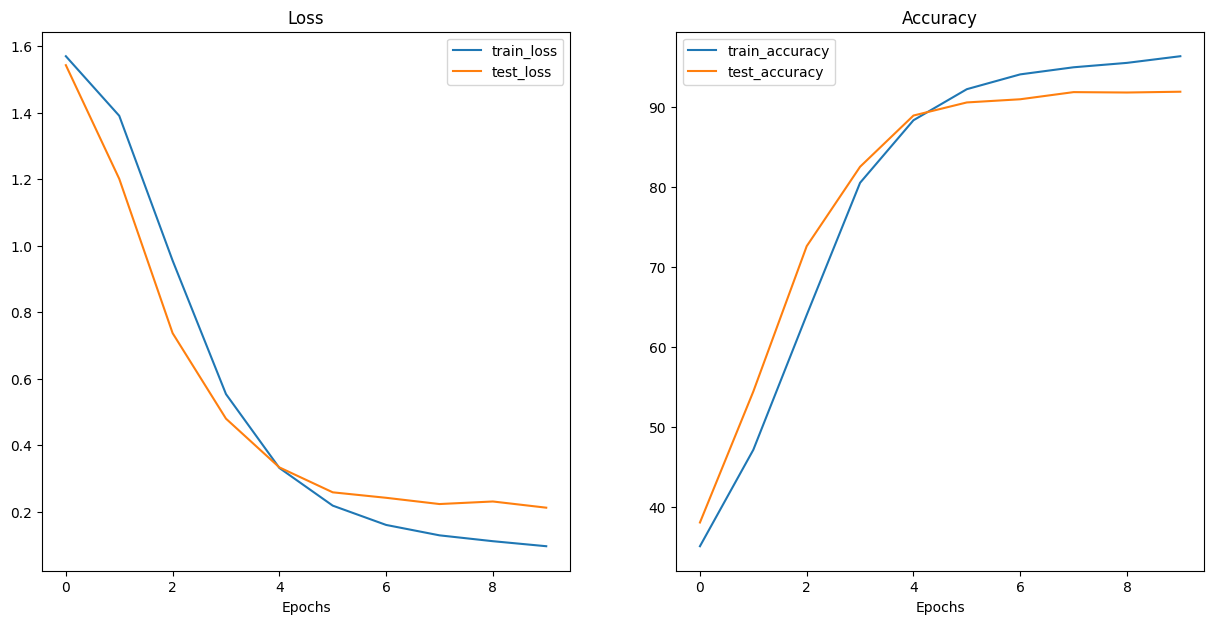

In [85]:
plot_loss_curves(results)

## Testing

In [86]:
y_preds, y_true = getPredsAndTrue(cnn_model, test_gen, device)

In [87]:
labels = ["sadness", "joy", "love", "fear", "surprise", "anger"]

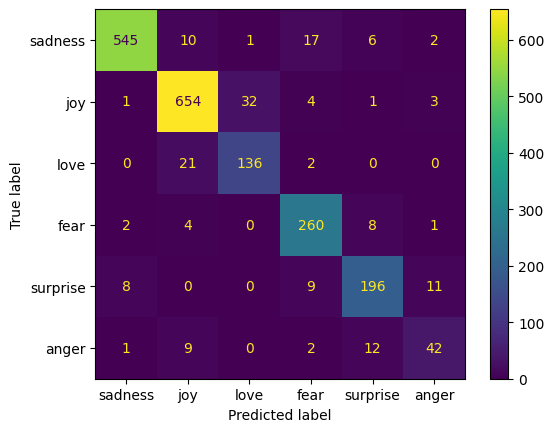

In [88]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()

In [89]:
y_preds, y_true = np.array(y_preds.cpu()), np.array(y_true.cpu())

In [90]:
test_texts = pd.DataFrame(ds['test'])['text']

In [91]:
miss_classifications = pd.DataFrame(
    {
    'text' : list(test_texts[y_true != y_preds]),
    'true label' : y_true[y_true != y_preds],
    'predicted label' : y_preds[y_true != y_preds]
    })

In [92]:
pp = pprint.PrettyPrinter()

In [93]:
def printMissClassifications(df):
    index = random.choice(miss_classifications.index)
    pp.pprint(miss_classifications.loc[index].text)
    print(f"True label ", labels[miss_classifications.loc[index]['true label']])
    print("Predicted  label ", labels[miss_classifications.loc[index]['predicted label']])

In [94]:
printMissClassifications(miss_classifications)

'i replied feeling strange at giving the orders'
True label  anger
Predicted  label  surprise


In [95]:
printMissClassifications(miss_classifications)

('i would always have this song stuck in my head after a bombing or incident '
 'and then i would feel a bit weird about it because if you dont really pay '
 'attention to the lyrics it sounds like such a happy song not the type youre '
 'supposed to hum on difficult days')
True label  surprise
Predicted  label  anger


In [96]:
printMissClassifications(miss_classifications)

('i grabbed my dog and hugged her fiercly for the next hour or so until i '
 'began to feel a bit like myself again but i havent completly shaken the '
 'feeling and have been feeling rather depressed anxious all day')
True label  surprise
Predicted  label  sadness
